# Beijing forcasting with RNN

This project demonstrates **time series forecasting** of air quality (PM2.5) in Beijing using a **Simple RNN** built with **TensorFlow/Keras**.  
It includes:

- Data preprocessing and interpolation
- Creating a time-indexed dataset
- Preparing training and test sequences for RNN
- Building, training, and evaluating a Simple RNN model
- Plotting predictions against actual PM2.5 readings

The notebook provides a hands-on example of **sequence modeling** and RNN fundamentals for forecasting tasks.

In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [3]:
df_beijing = pd.read_csv(
    filepath_or_buffer='Beijing.csv'
)

In [4]:
df_beijing = df_beijing[df_beijing.year >= 2015]
df_beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


In [5]:
df_beijing.shape

(8760, 18)

In [6]:
df_beijing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 43824 to 52583
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   No               8760 non-null   int64  
 1   year             8760 non-null   int64  
 2   month            8760 non-null   int64  
 3   day              8760 non-null   int64  
 4   hour             8760 non-null   int64  
 5   season           8760 non-null   int64  
 6   PM_Dongsi        8596 non-null   float64
 7   PM_Dongsihuan    5465 non-null   float64
 8   PM_Nongzhanguan  8473 non-null   float64
 9   PM_US Post       8631 non-null   float64
 10  DEWP             8755 non-null   float64
 11  HUMI             8421 non-null   float64
 12  PRES             8421 non-null   float64
 13  TEMP             8755 non-null   float64
 14  cbwd             8755 non-null   object 
 15  Iws              8755 non-null   float64
 16  precipitation    8301 non-null   float64
 17  Iprec         

In [7]:
df_beijing['PM_Dongsi'].interpolate(
    method='linear',
    limit=None,
    limit_direction='forward',
    inplace=True
)

df_beijing['TEMP'].interpolate(
    method='linear',
    limit=None,
    limit_direction='forward',
    inplace=True
)

In [8]:
df_beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,4.0,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


In [9]:
def make_date(row):
    return datetime(
        year = row['year'],
        month = row['month'],
        day = row['day'],
        hour = row['hour']
    )

df_beijing['date'] = df_beijing.apply(make_date, axis=1)

df_beijing.set_index(df_beijing.date, inplace=True)

df_beijing.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,date
date,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0,2015-01-01 00:00:00
2015-01-01 01:00:00,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0,2015-01-01 01:00:00
2015-01-01 02:00:00,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0,2015-01-01 02:00:00
2015-01-01 03:00:00,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0,2015-01-01 03:00:00
2015-01-01 04:00:00,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0,2015-01-01 04:00:00


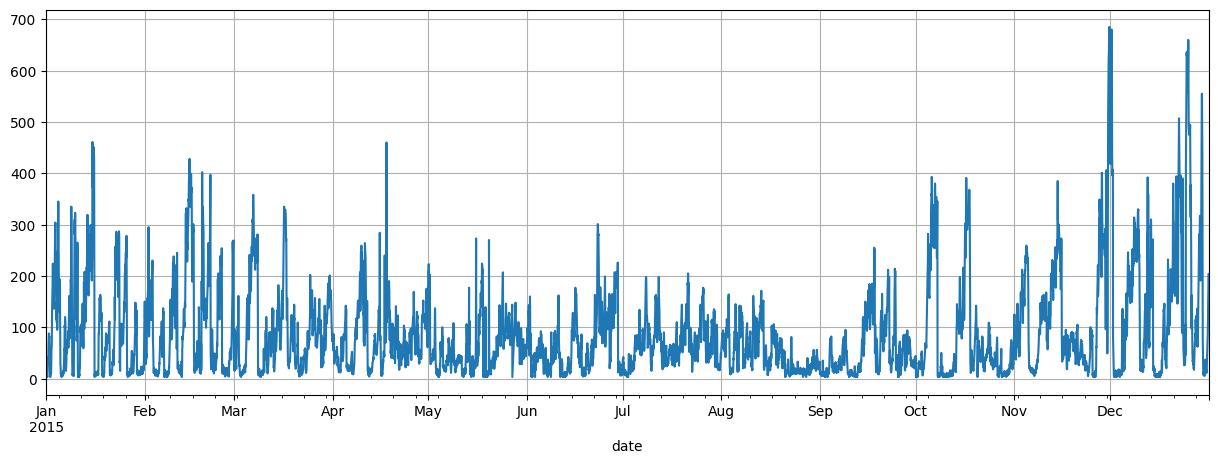

In [10]:
plt.figure(figsize=(15, 5))
df_beijing['PM_Dongsi'].plot()
plt.grid()

In [11]:
df_beijing['PM_Dongsi']

date
2015-01-01 00:00:00      5.0
2015-01-01 01:00:00      4.0
2015-01-01 02:00:00      3.0
2015-01-01 03:00:00      4.0
2015-01-01 04:00:00      3.0
                       ...  
2015-12-31 19:00:00    140.0
2015-12-31 20:00:00    157.0
2015-12-31 21:00:00    171.0
2015-12-31 22:00:00    204.0
2015-12-31 23:00:00    204.0
Name: PM_Dongsi, Length: 8760, dtype: float64

In [12]:
def get_n_last_days(df, series_name, n_days):
    return df[series_name][-(24 * n_days):]

In [13]:
def plot_n_last_days(df, series_name, n_days):
    plt.figure(figsize=(10, 5))
    plt.plot(
        get_n_last_days(df, series_name, n_days),
        'k-'
    )
    plt.title('Air Quality Time Series')
    plt.xlabel('Recorded Hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

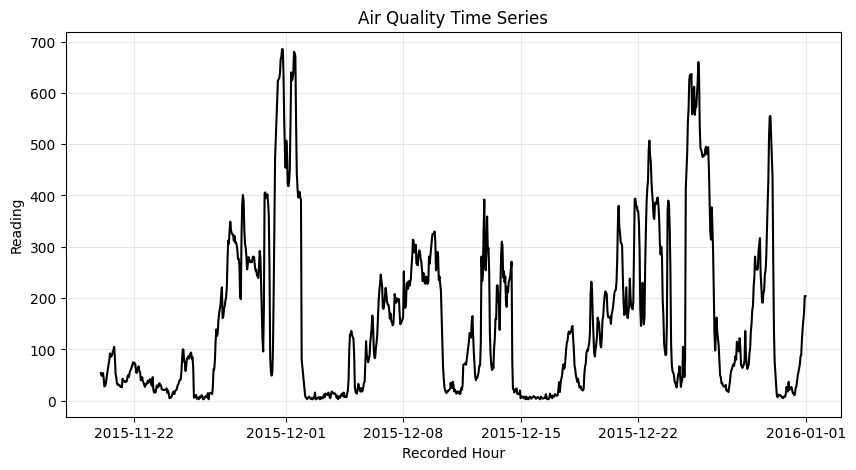

In [14]:
plot_n_last_days(
    df=df_beijing,
    series_name='PM_Dongsi',
    n_days=42
)

In [15]:
def get_keras_format_series(series):
    series = np.array(series)
    return series.reshape(
        series.shape[0],
        series.shape[1],
        1
    )

In [16]:
def get_train_test_data(df, series_name, series_days, input_hours, test_hours, sample_gap=3):
    forecast_series = get_n_last_days(df, series_name, series_days).values

    train = forecast_series[:-test_hours]
    test = forecast_series[-test_hours:]

    train_X, train_y = [], []

    for i in range(0, train.shape[0]-input_hours, sample_gap):
        train_X.append(train[i:i+input_hours])
        train_y.append(train[i+input_hours])

    train_X = get_keras_format_series(train_X)
    train_y = np.array(train_y)

    test_X_init = test[:input_hours]
    test_y = test[input_hours:]

    return train_X, test_X_init, train_y, test_y

In [17]:
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = (
    get_train_test_data(
        df_beijing,
        'PM_Dongsi',
        series_days,
        input_hours,
        test_hours
    )
)

In [18]:
type(test_y)

numpy.ndarray

In [19]:
train_X.shape

(436, 12, 1)

In [20]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    model = Sequential()

    model.add(
        SimpleRNN(
            cell_units,
            input_shape=(train_X.shape[1], 1)
        )
    )

    model.add(Dense(1))

    model.compile(
        loss='mean_squared_error',
        optimizer='adam'
    )

    model.fit(
        train_X,
        train_y,
        epochs=epochs,
        batch_size=64,
        verbose=0
    )

    return model

In [21]:
model = fit_SimpleRNN(
    train_X,
    train_y,
    cell_units=30,
    epochs=1200
)

In [27]:
def predict(x_init, n_steps, model):
    x_init = x_init.copy().reshape(1, -1, 1)
    preds = []

    for _ in range(n_steps):
        pred = model.predict(x_init)
        preds.append(pred)
        x_init[:, :-1, :] = x_init[:, 1:, :]
        x_init[:, -1, :] = pred

    preds = np.array(preds).reshape(-1, 1)

    return preds

In [23]:
y_preds = predict(
    test_X_init,
    n_steps=len(test_y),
    model=model
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


In [30]:
def predict_and_plot(x_init, y, model, title):
    y_preds = predict(
        x_init,
        n_steps=len(y),
        model=model
    )
    print(len(y_preds))
    start_range = range(len(x_init))
    predict_range = range(len(x_init), len(x_init)+len(y))
    print(len(predict_range))
    plt.plot(start_range, x_init)
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    plt.title(title)
    plt.legend(
        ['Initial Series', 'Target Series', 'Predictions']
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
12
12


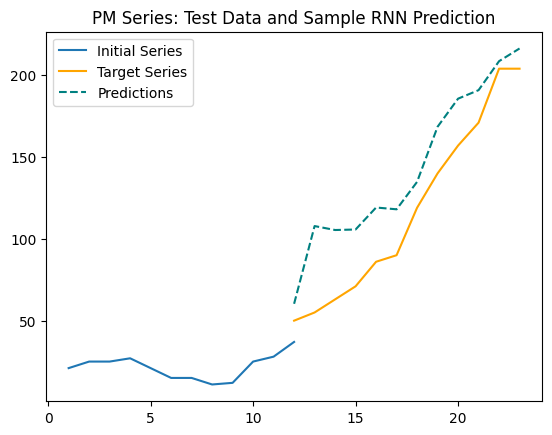

In [29]:
predict_and_plot(
    test_X_init,
    test_y,
    model,
    'PM Series: Test Data and Sample RNN Prediction'
)